In [1]:
import mxnet as mx
import gluonnlp as nlp

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sacremoses
import time
from tqdm.notebook import tqdm

# Local Libraries
import nmt
import dataprocessor
import utils
import nmt.gnmt_hparams

# Seeds for reproducibility
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

# CPU setup
# ctx = mx.cpu()
# Single GPU setup
ctx = mx.gpu(0)

[nltk_data] Downloading package punkt to /home/andreto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andreto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andreto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# IWSLT2015 Dataset (Train, Validation and Test)

# Dataset Parameters
src_lang, tgt_lang = "vi", "en"
src_max_len, tgt_max_len = 50, 50

iwslt_train_text = nlp.data.IWSLT2015("train",
                                      src_lang=src_lang,
                                      tgt_lang=tgt_lang)

iwslt_val_text   = nlp.data.IWSLT2015("val",
                                      src_lang=src_lang,
                                      tgt_lang=tgt_lang)

iwslt_test_text  = nlp.data.IWSLT2015("test",
                                      src_lang=src_lang,
                                      tgt_lang=tgt_lang)


iwslt_src_vocab = iwslt_train_text.src_vocab
iwslt_tgt_vocab = iwslt_train_text.tgt_vocab

/home/andreto/.local/lib/python3.7/site-packages/gluonnlp/vocab/vocab.py:591: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  'Detected a corrupted index in the deserialize vocabulary. '


In [3]:
print("Length of train set:", len(iwslt_train_text))
print("Length of val set  :", len(iwslt_val_text))
print("Length of test set :", len(iwslt_test_text))

Length of train set: 133166
Length of val set  : 1553
Length of test set : 1268


In [4]:
# Dataset processing: clipping, tokenizing, indexing and adding of EOS (src/tgt) / BOS (tgt)
iwslt_train_processed = iwslt_train_text.transform(
    dataprocessor.TrainValDataTransform(
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

iwslt_val_processed   = iwslt_val_text.transform(
    dataprocessor.TrainValDataTransform(
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

iwslt_test_processed  = iwslt_test_text.transform(
    dataprocessor.TrainValDataTransform(
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

In [5]:
# Target Sequences (Val, Test)
fetch_tgt_sentence = lambda src, tgt: tgt.split()
val_tgt_sentences = list(iwslt_val_text.transform(fetch_tgt_sentence))
test_tgt_sentences = list(iwslt_test_text.transform(fetch_tgt_sentence))

In [6]:
# Create Gluon Datasets (not for training, as training data will be sharded)
iwslt_train_transformed = iwslt_train_processed.transform(
    lambda src, tgt: (src, tgt, len(src), len(tgt)),
    lazy=False)

iwslt_val_dataset = mx.gluon.data.SimpleDataset(
    [(ele[0], ele[1], len(ele[0]), len(ele[1]),i) for i, ele in enumerate(iwslt_val_processed)])

iwslt_test_dataset = mx.gluon.data.SimpleDataset(
    [(ele[0], ele[1], len(ele[0]), len(ele[1]), i) for i, ele in enumerate(iwslt_test_processed)])

In [7]:
# Hyperparameters for Dataloaders and Training
hparams = nmt.gnmt_hparams

In [8]:
# Create Gluon Samplers and DataLoaders

# Helper function for lengths
def get_data_lengths(dataset):
    get_lengths = lambda *args: (args[2], args[3])
    return list(dataset.transform(get_lengths))

# Bucket scheme
bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)

iwslt_train_lengths = get_data_lengths(iwslt_train_transformed)
iwslt_val_lengths = get_data_lengths(iwslt_val_dataset)
iwslt_test_lengths = get_data_lengths(iwslt_test_dataset)

train_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'))

test_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack())

target_val_lengths = list(map(lambda x: x[-1], iwslt_val_lengths))
target_test_lengths = list(map(lambda x: x[-1], iwslt_test_lengths))

train_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=iwslt_train_lengths,
    batch_size=hparams.batch_size,
    num_buckets=hparams.num_buckets,
    ratio=0,
    shuffle=True,
    use_average_length=False,
    num_shards=0,
    bucket_scheme=bucket_scheme)
    
train_data_loader = nlp.data.ShardedDataLoader(
    iwslt_train_transformed,
    batch_sampler=train_batch_sampler,
    batchify_fn=train_batchify_fn,
    num_workers=8)

val_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=iwslt_val_lengths,
    batch_size=hparams.test_batch_size,
    num_buckets=hparams.num_buckets,
    ratio=0,
    shuffle=False,
    use_average_length=False,
    bucket_scheme=bucket_scheme)

val_data_loader = mx.gluon.data.DataLoader(
    iwslt_val_dataset,
    batch_sampler=val_batch_sampler,
    batchify_fn=test_batchify_fn,
    num_workers=8)

test_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=iwslt_test_lengths,
    batch_size=hparams.test_batch_size,
    num_buckets=hparams.num_buckets,
    ratio=0,
    shuffle=False,
    use_average_length=False,
    bucket_scheme=bucket_scheme)

test_data_loader = mx.gluon.data.DataLoader(
    iwslt_test_dataset,
    batch_sampler=test_batch_sampler,
    batchify_fn=test_batchify_fn,
    num_workers=8)

/home/andreto/.local/lib/python3.7/site-packages/gluonnlp/data/batchify/batchify.py:235: UserWarning: Padding value is not given and will be set automatically to 0 in data.batchify.Pad(). Please check whether this is intended (e.g. value of padding index in the vocabulary).
  'Padding value is not given and will be set automatically to 0 '


In [9]:
# GNMT Model
gnmt_encoder, gnmt_decoder, gnmt_one_step_ahead_decoder = nmt.gnmt.get_gnmt_encoder_decoder(
    hidden_size=hparams.num_hidden,
    dropout=hparams.dropout,
    num_layers=hparams.num_layers,
    num_bi_layers=hparams.num_bi_layers)

gnmt_model = nlp.model.translation.NMTModel(
    src_vocab=iwslt_src_vocab,
    tgt_vocab=iwslt_tgt_vocab,
    encoder=gnmt_encoder,
    decoder=gnmt_decoder,
    one_step_ahead_decoder=gnmt_one_step_ahead_decoder,
    embed_size=hparams.num_hidden,
    prefix='gnmt_')

gnmt_model.initialize(init=mx.init.Uniform(0.1), ctx=ctx)
static_alloc = True
gnmt_model.hybridize(static_alloc=static_alloc)

In [10]:
# Translator (using model defined above)
gnmt_translator = nmt.translation.BeamSearchTranslator(
    model=gnmt_model,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(
        alpha=hparams.lp_alpha,
        K=hparams.lp_k),
    max_length=150)

In [11]:
# Loss function
loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=static_alloc)

In [12]:
# Let's train
trainer = mx.gluon.Trainer(gnmt_model.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

train_losses = []
valid_losses = []
valid_bleus  = []
valid_perplexities = []

for epoch_id in tqdm(range(hparams.epochs)):

    log_loss = 0
    log_denom = 0
    log_avg_gnorm = 0
    log_wc = 0
    log_start_time = time.time()
    
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(train_data_loader)):
        
        src_seq = src_seq.as_in_context(ctx)
        tgt_seq = tgt_seq.as_in_context(ctx)
        src_valid_length = src_valid_length.as_in_context(ctx)
        tgt_valid_length = tgt_valid_length.as_in_context(ctx)
        
        with mx.autograd.record():
            out, _ = gnmt_model(
                src_seq,
                tgt_seq[:, :-1],
                src_valid_length,
                tgt_valid_length - 1)

            loss = loss_function(out, tgt_seq[:, 1:], tgt_valid_length - 1).mean()
            loss = loss * (tgt_seq.shape[1] - 1)
            log_loss += loss * tgt_seq.shape[0]
            log_denom += (tgt_valid_length - 1).sum()
            loss = loss / (tgt_valid_length - 1).mean()
            loss.backward()
        
        grads = [p.grad(ctx) for p in gnmt_model.collect_params().values() if p.grad_req != 'null']
        gnorm = mx.gluon.utils.clip_global_norm(grads, hparams.clip)
        trainer.step(1)
        
        src_wc = src_valid_length.sum().asscalar()
        tgt_wc = (tgt_valid_length - 1).sum().asscalar()
        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_avg_gnorm += gnorm
        log_wc += src_wc + tgt_wc
        
        train_loss = log_loss / log_denom
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, gnorm={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(train_data_loader),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 log_avg_gnorm / hparams.log_interval,
                                 wps / 1000, log_wc / 1000))
            
            log_start_time = time.time()
            log_loss = 0
            log_denom = 0
            log_avg_gnorm = 0
            log_wc = 0
            
    train_losses.append(train_loss)
    
    valid_loss, valid_translation_out = nmt.utils.evaluate(
        val_data_loader,
        gnmt_model,
        gnmt_translator,
        loss_function,
        iwslt_tgt_vocab,
        ctx)

    valid_perplexity = np.exp(valid_loss)
    valid_perplexities.append(valid_perplexity)
    
    valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([val_tgt_sentences], valid_translation_out)
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, valid_loss, valid_perplexity, valid_bleu_score * 100))
    
    valid_losses.append(valid_loss)
    valid_bleus.append(valid_bleu_score * 100)

    if valid_bleu_score > best_valid_bleu:
        best_valid_bleu = valid_bleu_score
        print("Save best parameters to {}".format(hparams.file_name))
        gnmt_model.save_parameters(hparams.file_name)
    
    if epoch_id + 1 >= (hparams.epochs * 2) // 3:
        new_lr = trainer.learning_rate * hparams.lr_update_factor
        print("Learning rate change to {}".format(new_lr))
        trainer.set_learning_rate(new_lr)

if os.path.exists(hparams.file_name):
    gnmt_model.load_parameters(hparams.file_name)

valid_loss, valid_translation_out = nmt.utils.evaluate(
    val_data_loader,
    gnmt_model,
    gnmt_translator,
    loss_function,
    iwslt_tgt_vocab,
    ctx)

valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([val_tgt_sentences], valid_translation_out)
print("Best model valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
      .format(valid_loss, np.exp(valid_loss), valid_bleu_score * 100))

test_loss, test_translation_out = nmt.utils.evaluate(
    test_data_loader,
    gnmt_model,
    gnmt_translator,
    loss_function,
    iwslt_tgt_vocab,
    ctx)

test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([test_tgt_sentences], test_translation_out)
print("Best model test Loss={:.4f}, test ppl={:.4f}, test bleu={:.2f}'"
      .format(test_loss, np.exp(test_loss), test_bleu_score * 100))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1043 [00:00<?, ?it/s]

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-08-08 20:46:41.502 ip-172-31-28-47:19462 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-08-08 20:46:41.532 ip-172-31-28-47:19462 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
[Epoch 0 Batch 100/1043] loss=6.3935, ppl=597.9448, gnorm=0.8397, throughput=33.91K wps, wc=606.57K
[Epoch 0 Batch 200/1043] loss=5.7033, ppl=299.8477, gnorm=0.4034, throughput=37.65K wps, wc=584.18K
[Epoch 0 Batch 300/1043] loss=5.2848, ppl=197.3192, gnorm=0.3523, throughput=39.65K wps, wc=592.78K
[Epoch 0 Batch 400/1043] loss=4.9782, ppl=145.2078, gnorm=0.3300, throug

  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 0] valid Loss=4.0851, valid ppl=59.4506, valid bleu=3.64
Save best parameters to gnmt_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 1 Batch 100/1043] loss=4.2704, ppl=71.5530, gnorm=0.3114, throughput=38.84K wps, wc=593.66K
[Epoch 1 Batch 200/1043] loss=4.2559, ppl=70.5235, gnorm=0.3018, throughput=39.81K wps, wc=631.62K
[Epoch 1 Batch 300/1043] loss=4.1719, ppl=64.8362, gnorm=0.2977, throughput=37.80K wps, wc=599.65K
[Epoch 1 Batch 400/1043] loss=4.0967, ppl=60.1445, gnorm=0.3012, throughput=38.89K wps, wc=585.70K
[Epoch 1 Batch 500/1043] loss=4.0121, ppl=55.2615, gnorm=0.3049, throughput=38.57K wps, wc=567.14K
[Epoch 1 Batch 600/1043] loss=3.9056, ppl=49.6791, gnorm=0.3192, throughput=38.02K wps, wc=521.63K
[Epoch 1 Batch 700/1043] loss=3.9479, ppl=51.8274, gnorm=0.3139, throughput=38.83K wps, wc=591.94K
[Epoch 1 Batch 800/1043] loss=3.8196, ppl=45.5859, gnorm=0.3272, throughput=38.75K wps, wc=563.74K
[Epoch 1 Batch 900/1043] loss=3.7051, ppl=40.6543, gnorm=0.3193, throughput=38.95K wps, wc=578.06K
[Epoch 1 Batch 1000/1043] loss=3.5597, ppl=35.1533, gnorm=0.3212, throughput=38.21K wps, wc=523.53K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 1] valid Loss=3.3799, valid ppl=29.3692, valid bleu=8.90
Save best parameters to gnmt_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 2 Batch 100/1043] loss=3.3892, ppl=29.6409, gnorm=0.3328, throughput=38.17K wps, wc=542.87K
[Epoch 2 Batch 200/1043] loss=3.3729, ppl=29.1625, gnorm=0.3293, throughput=38.55K wps, wc=575.69K
[Epoch 2 Batch 300/1043] loss=3.3198, ppl=27.6559, gnorm=0.3309, throughput=38.92K wps, wc=568.29K
[Epoch 2 Batch 400/1043] loss=3.2766, ppl=26.4848, gnorm=0.3328, throughput=38.55K wps, wc=578.89K
[Epoch 2 Batch 500/1043] loss=3.2317, ppl=25.3215, gnorm=0.3285, throughput=38.96K wps, wc=590.93K
[Epoch 2 Batch 600/1043] loss=3.1842, ppl=24.1482, gnorm=0.3325, throughput=38.79K wps, wc=561.47K
[Epoch 2 Batch 700/1043] loss=3.1901, ppl=24.2906, gnorm=0.3273, throughput=38.96K wps, wc=624.59K
[Epoch 2 Batch 800/1043] loss=3.0813, ppl=21.7870, gnorm=0.3301, throughput=38.99K wps, wc=564.54K
[Epoch 2 Batch 900/1043] loss=3.0838, ppl=21.8418, gnorm=0.3297, throughput=39.65K wps, wc=583.36K
[Epoch 2 Batch 1000/1043] loss=2.9733, ppl=19.5565, gnorm=0.3351, throughput=37.55K wps, wc=528.11K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 2] valid Loss=2.8992, valid ppl=18.1593, valid bleu=14.70
Save best parameters to gnmt_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 3 Batch 100/1043] loss=2.8944, ppl=18.0720, gnorm=0.3200, throughput=40.53K wps, wc=630.11K
[Epoch 3 Batch 200/1043] loss=2.8035, ppl=16.5016, gnorm=0.3369, throughput=39.19K wps, wc=572.70K
[Epoch 3 Batch 300/1043] loss=2.8324, ppl=16.9856, gnorm=0.3338, throughput=37.91K wps, wc=598.93K
[Epoch 3 Batch 400/1043] loss=2.7246, ppl=15.2502, gnorm=0.3417, throughput=38.63K wps, wc=537.22K
[Epoch 3 Batch 500/1043] loss=2.6959, ppl=14.8195, gnorm=0.3475, throughput=38.40K wps, wc=529.51K
[Epoch 3 Batch 600/1043] loss=2.7686, ppl=15.9368, gnorm=0.3263, throughput=38.90K wps, wc=610.71K
[Epoch 3 Batch 700/1043] loss=2.6648, ppl=14.3656, gnorm=0.3419, throughput=38.32K wps, wc=519.76K
[Epoch 3 Batch 800/1043] loss=2.6457, ppl=14.0934, gnorm=0.3375, throughput=38.16K wps, wc=539.30K
[Epoch 3 Batch 900/1043] loss=2.6764, ppl=14.5321, gnorm=0.3374, throughput=39.17K wps, wc=581.69K
[Epoch 3 Batch 1000/1043] loss=2.7022, ppl=14.9123, gnorm=0.3443, throughput=38.90K wps, wc=569.12K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 3] valid Loss=2.6615, valid ppl=14.3171, valid bleu=17.49
Save best parameters to gnmt_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 4 Batch 100/1043] loss=2.4440, ppl=11.5185, gnorm=0.3227, throughput=38.13K wps, wc=568.46K
[Epoch 4 Batch 200/1043] loss=2.4241, ppl=11.2921, gnorm=0.3358, throughput=36.97K wps, wc=542.90K
[Epoch 4 Batch 300/1043] loss=2.4502, ppl=11.5910, gnorm=0.3381, throughput=38.33K wps, wc=555.44K
[Epoch 4 Batch 400/1043] loss=2.4392, ppl=11.4638, gnorm=0.3409, throughput=38.12K wps, wc=543.93K
[Epoch 4 Batch 500/1043] loss=2.4675, ppl=11.7928, gnorm=0.3335, throughput=39.20K wps, wc=579.34K
[Epoch 4 Batch 600/1043] loss=2.4729, ppl=11.8571, gnorm=0.3402, throughput=38.88K wps, wc=601.62K
[Epoch 4 Batch 700/1043] loss=2.4927, ppl=12.0941, gnorm=0.3301, throughput=39.37K wps, wc=597.87K
[Epoch 4 Batch 800/1043] loss=2.3519, ppl=10.5053, gnorm=0.3409, throughput=37.82K wps, wc=507.35K
[Epoch 4 Batch 900/1043] loss=2.5161, ppl=12.3808, gnorm=0.3409, throughput=39.40K wps, wc=624.02K
[Epoch 4 Batch 1000/1043] loss=2.4486, ppl=11.5719, gnorm=0.3370, throughput=38.64K wps, wc=580.31K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 4] valid Loss=2.5682, valid ppl=13.0430, valid bleu=19.13
Save best parameters to gnmt_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 5 Batch 100/1043] loss=2.1533, ppl=8.6129, gnorm=0.3286, throughput=35.91K wps, wc=529.43K
[Epoch 5 Batch 200/1043] loss=2.2927, ppl=9.9016, gnorm=0.3291, throughput=39.41K wps, wc=611.54K
[Epoch 5 Batch 300/1043] loss=2.2506, ppl=9.4931, gnorm=0.3349, throughput=38.88K wps, wc=582.88K
[Epoch 5 Batch 400/1043] loss=2.2460, ppl=9.4497, gnorm=0.3376, throughput=38.57K wps, wc=556.31K
[Epoch 5 Batch 500/1043] loss=2.0782, ppl=7.9900, gnorm=0.3456, throughput=36.91K wps, wc=472.55K
[Epoch 5 Batch 600/1043] loss=2.2766, ppl=9.7435, gnorm=0.3352, throughput=38.73K wps, wc=586.79K
[Epoch 5 Batch 700/1043] loss=2.2373, ppl=9.3678, gnorm=0.3392, throughput=38.29K wps, wc=561.02K
[Epoch 5 Batch 800/1043] loss=2.2311, ppl=9.3096, gnorm=0.3385, throughput=38.69K wps, wc=555.63K
[Epoch 5 Batch 900/1043] loss=2.3012, ppl=9.9864, gnorm=0.3315, throughput=38.87K wps, wc=600.79K
[Epoch 5 Batch 1000/1043] loss=2.3782, ppl=10.7859, gnorm=0.3268, throughput=39.72K wps, wc=659.40K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] valid Loss=2.4984, valid ppl=12.1624, valid bleu=19.69
Save best parameters to gnmt_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 6 Batch 100/1043] loss=2.0759, ppl=7.9716, gnorm=0.3156, throughput=38.65K wps, wc=603.59K
[Epoch 6 Batch 200/1043] loss=2.0281, ppl=7.5995, gnorm=0.3301, throughput=37.39K wps, wc=562.11K
[Epoch 6 Batch 300/1043] loss=2.1225, ppl=8.3521, gnorm=0.3231, throughput=39.56K wps, wc=624.24K
[Epoch 6 Batch 400/1043] loss=2.1139, ppl=8.2808, gnorm=0.3286, throughput=38.08K wps, wc=603.10K
[Epoch 6 Batch 500/1043] loss=2.1032, ppl=8.1927, gnorm=0.3376, throughput=38.97K wps, wc=561.10K
[Epoch 6 Batch 600/1043] loss=2.1102, ppl=8.2499, gnorm=0.3453, throughput=39.07K wps, wc=565.55K
[Epoch 6 Batch 700/1043] loss=2.1177, ppl=8.3118, gnorm=0.3454, throughput=39.08K wps, wc=555.39K
[Epoch 6 Batch 800/1043] loss=2.0839, ppl=8.0361, gnorm=0.3456, throughput=37.99K wps, wc=537.32K
[Epoch 6 Batch 900/1043] loss=2.1490, ppl=8.5766, gnorm=0.3326, throughput=38.79K wps, wc=591.29K
[Epoch 6 Batch 1000/1043] loss=2.1207, ppl=8.3373, gnorm=0.3446, throughput=38.23K wps, wc=554.05K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 6] valid Loss=2.4948, valid ppl=12.1197, valid bleu=20.40
Save best parameters to gnmt_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 7 Batch 100/1043] loss=1.9646, ppl=7.1323, gnorm=0.3205, throughput=38.80K wps, wc=587.59K
[Epoch 7 Batch 200/1043] loss=2.0012, ppl=7.3983, gnorm=0.3232, throughput=38.31K wps, wc=622.04K
[Epoch 7 Batch 300/1043] loss=1.8897, ppl=6.6177, gnorm=0.3344, throughput=38.00K wps, wc=540.54K
[Epoch 7 Batch 400/1043] loss=1.8521, ppl=6.3735, gnorm=0.3431, throughput=35.82K wps, wc=502.07K
[Epoch 7 Batch 500/1043] loss=1.9833, ppl=7.2666, gnorm=0.3385, throughput=38.92K wps, wc=583.79K
[Epoch 7 Batch 600/1043] loss=2.0343, ppl=7.6466, gnorm=0.3329, throughput=38.34K wps, wc=609.75K
[Epoch 7 Batch 700/1043] loss=2.0013, ppl=7.3983, gnorm=0.3395, throughput=37.46K wps, wc=577.30K
[Epoch 7 Batch 800/1043] loss=1.8983, ppl=6.6745, gnorm=0.3528, throughput=37.78K wps, wc=505.00K
[Epoch 7 Batch 900/1043] loss=2.0041, ppl=7.4196, gnorm=0.3367, throughput=39.00K wps, wc=590.09K
[Epoch 7 Batch 1000/1043] loss=2.0490, ppl=7.7599, gnorm=0.3333, throughput=37.71K wps, wc=599.85K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 7] valid Loss=2.4834, valid ppl=11.9825, valid bleu=20.16
Learning rate change to 0.0005


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 8 Batch 100/1043] loss=1.7350, ppl=5.6687, gnorm=0.3158, throughput=36.68K wps, wc=556.55K
[Epoch 8 Batch 200/1043] loss=1.8212, ppl=6.1793, gnorm=0.3118, throughput=38.35K wps, wc=601.04K
[Epoch 8 Batch 300/1043] loss=1.8334, ppl=6.2550, gnorm=0.3128, throughput=37.73K wps, wc=614.51K
[Epoch 8 Batch 400/1043] loss=1.7186, ppl=5.5769, gnorm=0.3232, throughput=37.15K wps, wc=539.14K
[Epoch 8 Batch 500/1043] loss=1.7637, ppl=5.8342, gnorm=0.3206, throughput=38.97K wps, wc=561.68K
[Epoch 8 Batch 600/1043] loss=1.7742, ppl=5.8959, gnorm=0.3243, throughput=38.66K wps, wc=567.04K
[Epoch 8 Batch 700/1043] loss=1.8346, ppl=6.2629, gnorm=0.3195, throughput=39.70K wps, wc=600.47K
[Epoch 8 Batch 800/1043] loss=1.8354, ppl=6.2676, gnorm=0.3190, throughput=39.49K wps, wc=610.25K
[Epoch 8 Batch 900/1043] loss=1.7542, ppl=5.7787, gnorm=0.3254, throughput=38.42K wps, wc=562.08K
[Epoch 8 Batch 1000/1043] loss=1.7209, ppl=5.5896, gnorm=0.3315, throughput=37.59K wps, wc=530.23K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 8] valid Loss=2.4890, valid ppl=12.0489, valid bleu=20.65
Save best parameters to gnmt_vi_en_512.params
Learning rate change to 0.00025


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 9 Batch 100/1043] loss=1.6790, ppl=5.3603, gnorm=0.3064, throughput=38.94K wps, wc=576.48K
[Epoch 9 Batch 200/1043] loss=1.6123, ppl=5.0142, gnorm=0.3105, throughput=37.21K wps, wc=550.86K
[Epoch 9 Batch 300/1043] loss=1.7651, ppl=5.8420, gnorm=0.3097, throughput=39.65K wps, wc=633.26K
[Epoch 9 Batch 400/1043] loss=1.7021, ppl=5.4855, gnorm=0.3172, throughput=38.51K wps, wc=579.86K
[Epoch 9 Batch 500/1043] loss=1.6041, ppl=4.9733, gnorm=0.3162, throughput=38.31K wps, wc=543.97K
[Epoch 9 Batch 600/1043] loss=1.6346, ppl=5.1275, gnorm=0.3148, throughput=37.86K wps, wc=547.23K
[Epoch 9 Batch 700/1043] loss=1.6347, ppl=5.1280, gnorm=0.3203, throughput=38.29K wps, wc=580.76K
[Epoch 9 Batch 800/1043] loss=1.5692, ppl=4.8029, gnorm=0.3183, throughput=38.42K wps, wc=533.16K
[Epoch 9 Batch 900/1043] loss=1.6586, ppl=5.2520, gnorm=0.3158, throughput=38.85K wps, wc=583.95K
[Epoch 9 Batch 1000/1043] loss=1.7123, ppl=5.5418, gnorm=0.3167, throughput=39.58K wps, wc=601.85K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 9] valid Loss=2.4916, valid ppl=12.0812, valid bleu=20.94
Save best parameters to gnmt_vi_en_512.params
Learning rate change to 0.000125


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 10 Batch 100/1043] loss=1.6974, ppl=5.4595, gnorm=0.3012, throughput=39.25K wps, wc=616.40K
[Epoch 10 Batch 200/1043] loss=1.5162, ppl=4.5548, gnorm=0.3158, throughput=36.91K wps, wc=530.46K
[Epoch 10 Batch 300/1043] loss=1.4959, ppl=4.4633, gnorm=0.3128, throughput=37.28K wps, wc=528.15K
[Epoch 10 Batch 400/1043] loss=1.5305, ppl=4.6205, gnorm=0.3125, throughput=38.33K wps, wc=552.92K
[Epoch 10 Batch 500/1043] loss=1.4883, ppl=4.4294, gnorm=0.3150, throughput=38.13K wps, wc=518.86K
[Epoch 10 Batch 600/1043] loss=1.6714, ppl=5.3196, gnorm=0.3097, throughput=39.98K wps, wc=630.69K
[Epoch 10 Batch 700/1043] loss=1.5638, ppl=4.7771, gnorm=0.3130, throughput=38.14K wps, wc=555.67K
[Epoch 10 Batch 800/1043] loss=1.6141, ppl=5.0236, gnorm=0.3115, throughput=39.17K wps, wc=582.86K
[Epoch 10 Batch 900/1043] loss=1.6967, ppl=5.4561, gnorm=0.3048, throughput=39.60K wps, wc=647.88K
[Epoch 10 Batch 1000/1043] loss=1.6583, ppl=5.2501, gnorm=0.3128, throughput=39.22K wps, wc=611.42K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] valid Loss=2.5021, valid ppl=12.2086, valid bleu=20.96
Save best parameters to gnmt_vi_en_512.params
Learning rate change to 6.25e-05


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 11 Batch 100/1043] loss=1.5881, ppl=4.8943, gnorm=0.3044, throughput=38.81K wps, wc=594.99K
[Epoch 11 Batch 200/1043] loss=1.4950, ppl=4.4594, gnorm=0.3076, throughput=37.95K wps, wc=550.29K
[Epoch 11 Batch 300/1043] loss=1.5416, ppl=4.6722, gnorm=0.3092, throughput=38.04K wps, wc=567.04K
[Epoch 11 Batch 400/1043] loss=1.5250, ppl=4.5951, gnorm=0.3075, throughput=37.72K wps, wc=535.70K
[Epoch 11 Batch 500/1043] loss=1.5593, ppl=4.7555, gnorm=0.3100, throughput=38.14K wps, wc=582.91K
[Epoch 11 Batch 600/1043] loss=1.4932, ppl=4.4512, gnorm=0.3127, throughput=37.98K wps, wc=555.74K
[Epoch 11 Batch 700/1043] loss=1.5215, ppl=4.5793, gnorm=0.3134, throughput=37.66K wps, wc=553.90K
[Epoch 11 Batch 800/1043] loss=1.6580, ppl=5.2487, gnorm=0.3110, throughput=39.63K wps, wc=618.74K
[Epoch 11 Batch 900/1043] loss=1.5816, ppl=4.8628, gnorm=0.3091, throughput=39.02K wps, wc=593.70K
[Epoch 11 Batch 1000/1043] loss=1.6163, ppl=5.0345, gnorm=0.3148, throughput=38.27K wps, wc=589.68K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 11] valid Loss=2.5078, valid ppl=12.2782, valid bleu=20.97
Save best parameters to gnmt_vi_en_512.params
Learning rate change to 3.125e-05


  0%|          | 0/27 [00:00<?, ?it/s]

Best model valid Loss=2.5078, valid ppl=12.2782, valid bleu=20.97


  0%|          | 0/23 [00:00<?, ?it/s]

Best model test Loss=2.3807, test ppl=10.8130, test bleu=23.15'


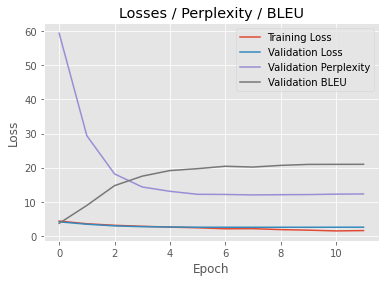

In [15]:
# plot losses and validation accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, hparams.epochs), train_losses, label="Training Loss")
plt.plot(range(0, hparams.epochs), valid_losses, label="Validation Loss")
plt.plot(range(0, hparams.epochs), valid_perplexities, label="Validation Perplexity")
plt.plot(range(0, hparams.epochs), valid_bleus, label="Validation BLEU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses / Perplexity / BLEU")
plt.show()

In [14]:
print("Qualitative Evaluation: Translating from Vietnamese to English")

expected_tgt_seq = "I like to read books."
print("Expected translation:")
print(expected_tgt_seq)
# From Google Translate
src_seq = "Tôi thích đọc sách kỹ thuật."
print("In Vietnamese (from Google Translate):")
print(src_seq)

translation_out = nmt.utils.translate(
    gnmt_translator,
    src_seq,
    iwslt_src_vocab,
    iwslt_tgt_vocab,
    ctx)

print("The English translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read books .
